In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch 
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from utils import *
from models import *
from tqdm import tqdm

import matplotlib.pyplot as plt

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
d = 3
m = 8
t = 200
n = 100000
lamda = 0.2
distance = 0.1
coherent = False

array_nested = NestedArray1D(m, lamda)
array_nested.build_sensor_positions(distance, [4, 4])

torch.manual_seed(30)
del_xy = torch.rand(2, 8) * 0.06 - 0.03
array_nested.pertube(del_xy[0], del_xy[1])

array_nested_nominal = NestedArray1D(m, lamda)
array_nested_nominal.build_sensor_positions(distance, [4, 4])
array_nested_nominal.build_array_manifold()

loss_cpu = RMSPE(d, 'cpu')
loss_cuda = RMSPE(d, 'cuda')

path = 'saved_models/'

SNRs = [0, 5, 10, 15, 20]
methods = []
mean_mse = {}

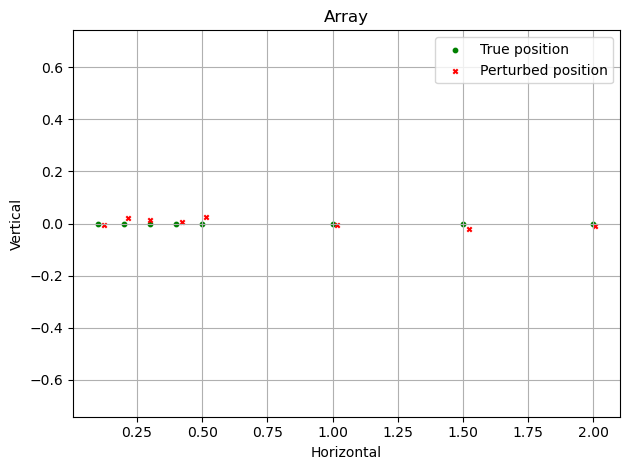

In [4]:
array_nested.plot_array()

In [5]:
torch.manual_seed(torch.seed())

In [6]:
methods.append("Nested Array MUSIC(R=180)")
mean_mse["Nested Array MUSIC(R=180)"] = []
music_180_nested = MUSIC(d, array_nested_nominal, -torch.pi/2, torch.pi/2, 180)

for snr in SNRs:

    observations, angles = generate_data(n, t, d, snr, snr, array_nested, False, coherent)

    results_music_180_nested = []
    for i in range(observations.shape[0]):
        theta_est, _, _ = music_180_nested.estimate(observations[i].T)
        results_music_180_nested.append(theta_est)
    results_music_180_nested = torch.stack(results_music_180_nested, dim=0)
    
    mse_music_180_nested = loss_cpu(results_music_180_nested, angles)
    mean_mse['Nested Array MUSIC(R=180)'].append(mse_music_180_nested)

In [7]:
methods.append("Nested Array MUSIC(R=360)")
mean_mse["Nested Array MUSIC(R=360)"] = []
music_360_nested = MUSIC(d, array_nested_nominal, -torch.pi/2, torch.pi/2, 360)

for snr in SNRs:

    observations, angles = generate_data(n, t, d, snr, snr, array_nested, False, coherent)

    results_music_360_nested = []
    for i in range(observations.shape[0]):
        theta_est, _, _ = music_360_nested.estimate(observations[i].T)
        results_music_360_nested.append(theta_est)
    results_music_360_nested = torch.stack(results_music_360_nested, dim=0)
    
    mse_music_360_nested = loss_cpu(results_music_360_nested, angles)
    mean_mse['Nested Array MUSIC(R=360)'].append(mse_music_360_nested)

In [8]:
methods.append("Nested Array MUSIC(R=1800)")
mean_mse["Nested Array MUSIC(R=1800)"] = []
music_1800_nested = MUSIC(d, array_nested_nominal, -torch.pi/2, torch.pi/2, 1800)

for snr in SNRs:

    observations, angles = generate_data(n, t, d, snr, snr, array_nested, False, coherent)

    results_music_1800_nested = []
    for i in range(observations.shape[0]):
        theta_est, _, _ = music_1800_nested.estimate(observations[i].T)
        results_music_1800_nested.append(theta_est)
    results_music_1800_nested = torch.stack(results_music_1800_nested, dim=0)
    
    mse_music_1800_nested = loss_cpu(results_music_1800_nested, angles)
    mean_mse['Nested Array MUSIC(R=1800)'].append(mse_music_1800_nested)

In [9]:
methods.append("Nested Array DA-MUSIC")
mean_mse["Nested Array DA-MUSIC"] = []

for snr in SNRs:

    observations, angles = generate_data(n, t, d, snr, snr, array_nested, False, coherent)

    test_set = DATASET(observations, angles)
    test_loader = DataLoader(test_set, batch_size=512, shuffle=False)

    da_music = DA_MUSIC(m, d, array_nested_nominal, dev)
    mean_mse['Nested Array DA-MUSIC'].append(test(da_music, test_loader, path+'da_music_'+str(snr)+'dB_nested.pth', loss_cuda, dev))

In [10]:
methods.append("Nested Array DA-MUSIC v2")
mean_mse["Nested Array DA-MUSIC v2"] = []

for snr in SNRs:

    observations, angles = generate_data(n, t, d, snr, snr, array_nested, False, coherent)

    test_set = DATASET(observations, angles)
    test_loader = DataLoader(test_set, batch_size=512, shuffle=False)

    da_music_v2 = DA_MUSIC_v2(m, d, array_nested_nominal, dev)
    mean_mse['Nested Array DA-MUSIC v2'].append(test(da_music_v2, test_loader, path+'da_music_v2_'+str(snr)+'dB_nested.pth', loss_cuda, dev))

In [11]:
methods.append("Nested Array RNN")
mean_mse["Nested Array RNN"] = []

for snr in SNRs:

    observations, angles = generate_data(n, t, d, snr, snr, array_nested, False, coherent)

    test_set = DATASET(observations, angles)
    test_loader = DataLoader(test_set, batch_size=512, shuffle=False)

    rnn = RNN(m, d, dev)
    mean_mse['Nested Array RNN'].append(test(rnn, test_loader, path+'rnn_'+str(snr)+'dB_nested.pth', loss_cuda, dev))

In [12]:
torch.save(mean_mse, 'mean_mse.pth')

/tmp/ipykernel_12071/2877243794.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mean_mse = torch.load('mean_mse.pth')


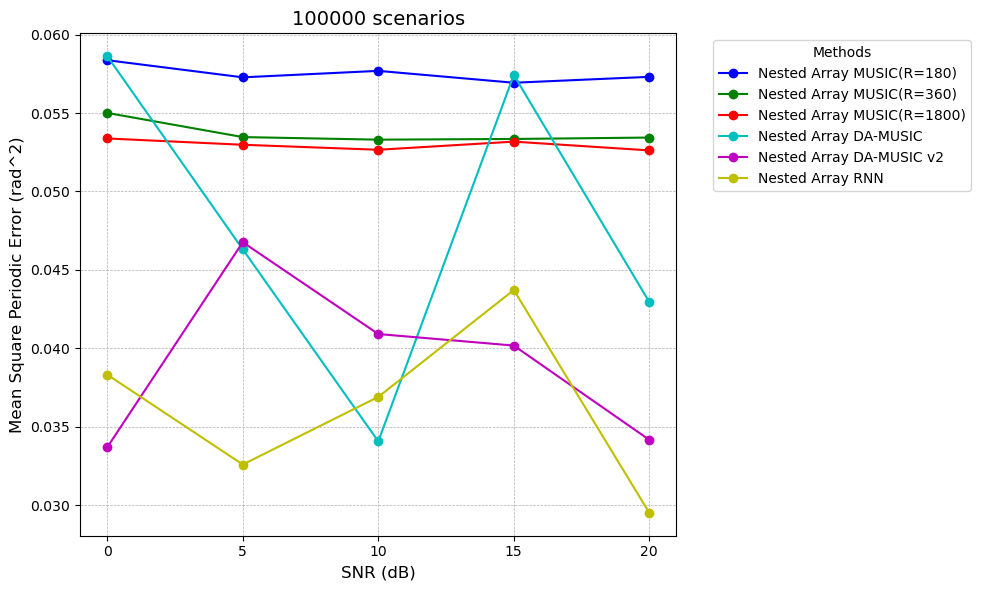

In [13]:
mean_mse = torch.load('mean_mse.pth')

plt.figure(figsize=(10, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown', 'pink', 'gray']

for i, method in enumerate(methods):
    plt.plot(SNRs, mean_mse[method], marker='o', label=method, color=colors[i])

# plt.yscale("log")
plt.title("{} scenarios".format(n), fontsize=14)
plt.xlabel("SNR (dB)", fontsize=12)
plt.ylabel("Mean Square Periodic Error (rad^2)", fontsize=12)
plt.xticks(SNRs)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend(title="Methods", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()